In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
modelo = tf.keras.models.load_model('./2R4P2R_latpar_2R2P2R_64.h5')
modelo.trainable = False

In [6]:
def get_xrd(name = str, skiprows=0):
    df = pd.read_csv(name, skiprows=0)
    
    xrd = df.values
    maxval = np.max(xrd[:,1])
    xrd[:,1] = xrd[:,1]/maxval
    
    return xrd

In [7]:
xrd = get_xrd(name='./Fluoresceina_interpolated.csv', skiprows=0)

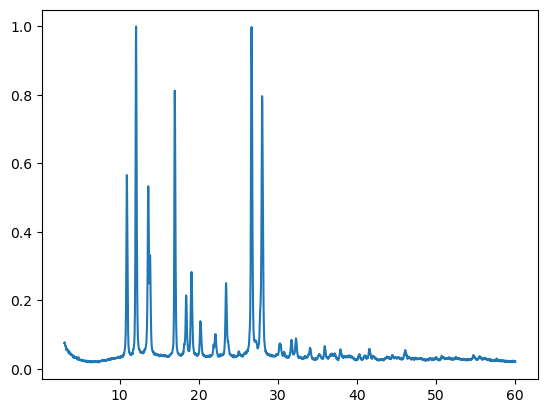

In [8]:
plt.figure()
plt.plot(xrd[:,0], xrd[:,1])
plt.show()

In [9]:
formula = 'C20H12O5'
atdict = {1:12, 6:20, 8:5}

In [10]:
zmax = 5

In [11]:
def create_binrep(atdict=dict, zmax=1):
    binrep = np.zeros((zmax, 96, 9))
    for z in range(1, zmax+1):
        for key in atdict.keys():
            atoms = int(z*atdict[key])
            ibin = np.asarray([int(i) for i in bin(atoms)[2:]])
            binrep[z-1,key-1,-len(ibin):] = ibin
    return binrep

In [12]:
x2 = create_binrep(atdict=atdict, zmax=zmax)

In [13]:
x1 = xrd[-2780:,1]
x1 = x1[np.newaxis,:,np.newaxis]
x1 = np.repeat(x1, x2.shape[0], axis=0)

In [14]:
d = modelo.predict([x1, x2], verbose=1)

1/1 [==============================] - 7s 7s/step


In [15]:
d[:,:3]

array([[12.536162 ,  9.231578 ,  6.049797 ],
       [13.844536 , 10.458847 ,  7.5124483],
       [14.942825 , 11.475635 ,  8.876013 ],
       [16.088005 , 12.343542 ,  9.696943 ],
       [17.616325 , 13.20683  ,  9.917376 ]], dtype=float32)

In [16]:
drmse = np.asarray([1.5682, 1.0771, 0.7751])
vrmse = 295


In [17]:
d = d[:,:3]
dmin = d - 2*drmse
dmax = d + 2*drmse

d = np.round(d, 4)
dmin = np.round(dmin, 4)
dmax = np.round(dmax, 4)

v = d[:,0]*d[:,1]*d[:,2]
vmin = v - 2*vrmse
vmax = v + 2*vrmse

v = v[:, np.newaxis]
vmin = vmin[:, np.newaxis]
vmax = vmax[:, np.newaxis]

v = np.round(v, 0)
vmin = np.round(vmin, 0)
vmax = np.round(vmax, 0)

z = np.arange(1, d.shape[0]+1, 1)
z = z[:,np.newaxis]

In [18]:
da = pd.DataFrame(np.concatenate((z, d, dmin, dmax, v, vmin, vmax), axis=1))
da = da.rename(columns = {0:'z', 
                1:'a', 2:'b', 3:'c',
                4:'amin', 5:'bmin', 6:'cmin',
                7:'amax', 8:'bmax', 9:'cmax',
                10:'v', 11:'vmin', 12:'vmax'
               })

In [19]:
da.round(4).to_csv('fluoresceina_sg.csv', index=None)